In [101]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.optimize import differential_evolution
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
from mplsoccer import Pitch

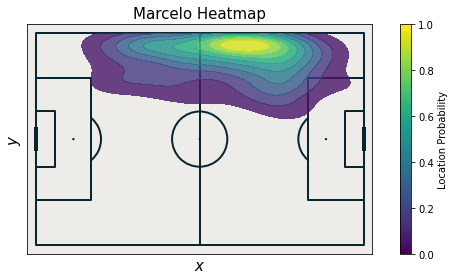

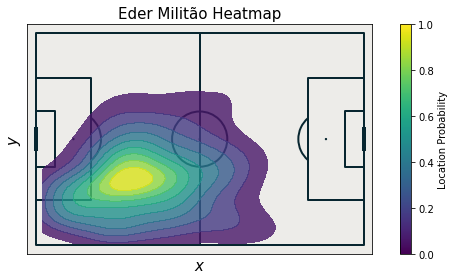

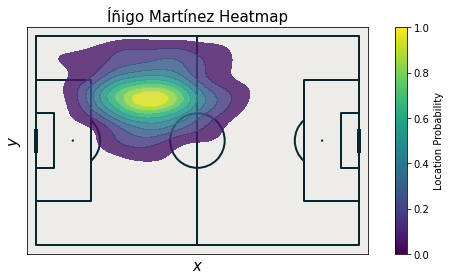

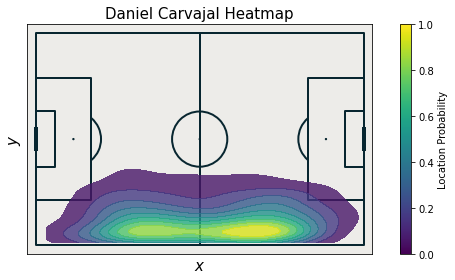

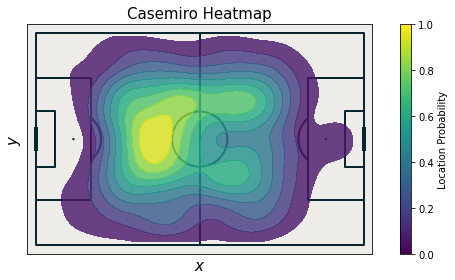

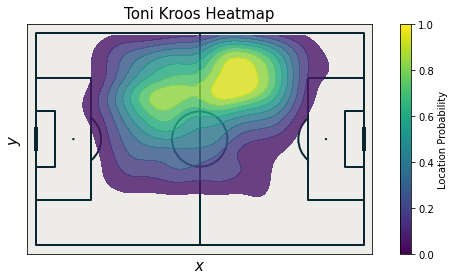

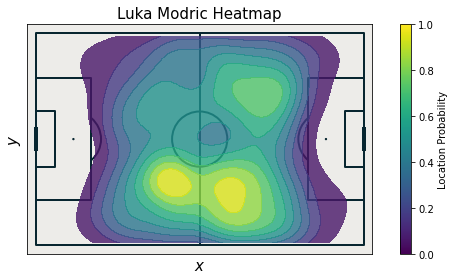

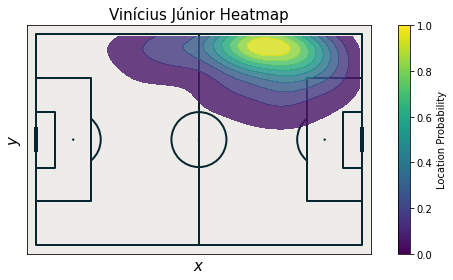

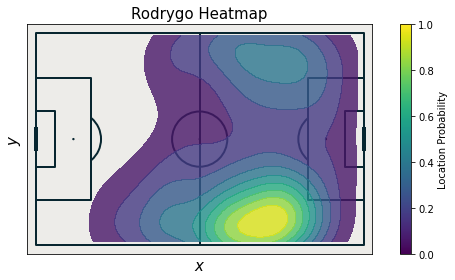

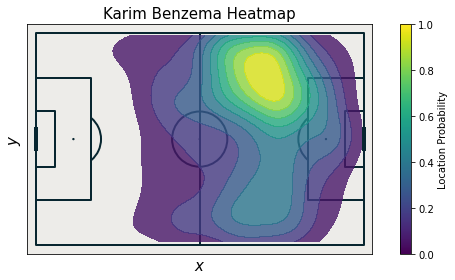

In [10]:
# Read data
data = pd.read_csv("WalkthroughLaLiga.csv")

# Define the player names
Real_Madrid = [
    "Marcelo",           # Left-back
    "Eder Militão",      # Center-back
    "Íñigo Martínez",    # Center-back
    "Daniel Carvajal",   # Right-back
    "Casemiro",          # Defensive Midfielder
    "Toni Kroos",        # Central Midfielder
    "Luka Modric",       # Central Midfielder
    "Vinícius Júnior",   # Left Winger
    "Rodrygo",           # Right Winger
    "Karim Benzema"      # Striker
]

# Create pitch object with 120 x 80 dimensions
pitch = Pitch(pitch_type='opta', pitch_color='#edece9', axis=True, label=False, line_color='#082630', tick=False)

# Initialize a 3D array to store probabilities for each player (10 players x 120 x 80)
probability_matrix = np.zeros((len(Real_Madrid), 120, 80))

# Plot KDE heat maps and contour plots for selected players
for i, player in enumerate(Real_Madrid):
    # Filter dataframe to only include passes received by the selected player
    player_data = data[data['receiver'] == player]
    
    # Calculate KDE
    kde = gaussian_kde(np.vstack([player_data.end_x, player_data.end_y]))
    
    # Evaluate KDE probabilities at each x, y coordinate
    x_grid, y_grid = np.mgrid[
        min(player_data.end_x):max(player_data.end_x):120j,
        min(player_data.end_y):max(player_data.end_y):80j
    ]
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
    prob = kde(positions).reshape(x_grid.shape)
    prob = prob / np.max(prob)  # normalize
    
    # Store probability matrix in the 3D array
    probability_matrix[i] = prob
    
    # Plot KDE heat map
    fig, ax = pitch.draw(figsize=(8, 4))
    
    # Overlay contour plot directly on the pitch
    ax.contourf(x_grid, y_grid, prob, cmap='viridis', alpha=.8, locator=ticker.MaxNLocator(prune='lower'))
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis')
    sm.set_array([])  # Set dummy array to ensure the colorbar knows the range of values
    colorbar = plt.colorbar(sm, ax=ax)
    colorbar.set_label('Location Probability')

    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title(f'{player} Heatmap', fontsize=15)
    
    plt.show()






Final optimized positions:
Marcelo: [50.95850003 48.86234784]
Eder Militão: [61.17005455 39.99999999]
Íñigo Martínez: [49.97663881 55.90165788]
Daniel Carvajal: [55.61665866 28.87666825]
Casemiro: [52.46660149 43.40692218]
Toni Kroos: [107.  72.]
Luka Modric: [52.19177685 56.30993026]
Vinícius Júnior: [51.32387174 69.215127  ]
Rodrygo: [50.1156859  23.29477137]
Karim Benzema: [53.33677754 59.39519186]
Total number of iterations: 10000


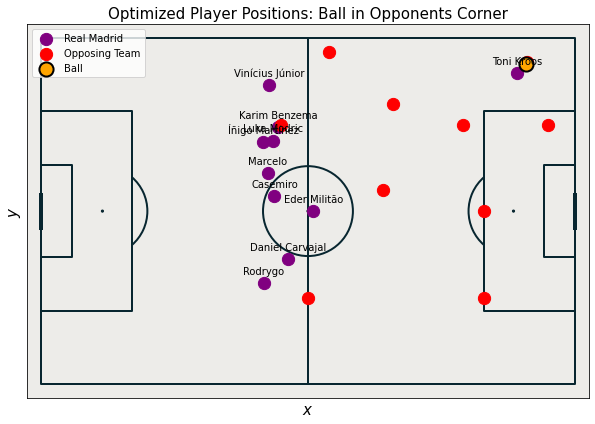

In [48]:
# Function to count iterations in optimization
iteration_count = 0
def iteration_callback(xk, convergence):
    global iteration_count
    iteration_count += 1
    print(f"Iteration: {iteration_count}", end='\r')

# Objective function to minimize
def objective(x, probability_matrix, opposing_positions, ball_position, goal_position):
    n_players = len(Real_Madrid)
    optimized_positions = x.reshape((n_players, 2))
    team_probability = 0
    clustering_penalty = 0
    guard_penalty = 0
    offside_penalty = 0

    for player_idx in range(n_players):
        x_idx = int(np.clip(optimized_positions[player_idx, 0], 0, 119))
        y_idx = int(np.clip(optimized_positions[player_idx, 1], 0, 79))
        probability_penalty = 1 / (probability_matrix[player_idx, x_idx, y_idx] + 1e-10)
        team_probability += probability_penalty

        # Calculate distance between the current player and all other players
        for other_idx in range(n_players):
            if other_idx != player_idx:
                distance = np.linalg.norm(optimized_positions[player_idx] - optimized_positions[other_idx])
                if distance < min_distance:
                    clustering_penalty += (min_distance - distance) ** 2

        # Calculate guard penalty
        distance_to_opp = np.linalg.norm(optimized_positions[player_idx] - opposing_positions[player_idx])
        goal_distance = np.linalg.norm(goal_position - opposing_positions[player_idx])
        projected_x = (goal_position[0] - opposing_positions[player_idx][0]) * (distance_to_opp / goal_distance) + opposing_positions[player_idx][0]
        projected_y = (goal_position[1] - opposing_positions[player_idx][1]) * (distance_to_opp / goal_distance) + opposing_positions[player_idx][1]
        guard_penalty += np.linalg.norm([projected_x, projected_y] - optimized_positions[player_idx]) * guard_penalty_weight

        # Offside constraint: push defensive line up if the ball is far up the field
        if ball_position[0] > offside_threshold:
            offside_penalty += (optimized_positions[player_idx, 0] - offside_threshold) ** 2 if optimized_positions[player_idx, 0] < offside_threshold else 0

    # Combine individual player probability, clustering penalty, guard penalty, and team probability
    objective_value = (1 - team_weight) * team_probability + clustering_penalty + guard_penalty + offside_penalty

    return objective_value

# Optimization with differential evolution from scipy
def optimize():
    n_players = len(Real_Madrid)
    bounds = [(0, 119), (0, 79)] * n_players  # n pairs of (0, 119) for (x, y) coordinates
    result = differential_evolution(objective, bounds, args=(probability_matrix, opposing_positions, ball_position, goal_position), strategy='best1bin', 
                                    popsize=5, tol=1e-4, mutation=(0.5, 1), recombination=0.7, seed=42, callback=iteration_callback, maxiter=10000)
    return result

# Main loop to optimize positions
result = optimize()
optimized_positions = result.x.reshape((len(Real_Madrid), 2))

# Assign the closest Real Madrid player to pressure the ball
closest_player_idx = np.argmin(np.linalg.norm(optimized_positions - ball_position, axis=1))
optimized_positions[closest_player_idx] = ball_position - 2

# Scale optimized positions to fit the 100x100 pitch dimensions
optimized_positions_scaled = np.zeros_like(optimized_positions)
optimized_positions_scaled[:, 0] = optimized_positions[:, 0] * (100 / 120)
optimized_positions_scaled[:, 1] = optimized_positions[:, 1] * (100 / 80)

# Print final positions of each player
print("Final optimized positions:")
for i, player in enumerate(Real_Madrid):
    print(f"{player}: {optimized_positions[i]}")

# Print the total number of iterations
print(f"Total number of iterations: {iteration_count}")

# Plot the optimized positions and save the figure
fig, ax = pitch.draw(figsize=(10, 6))

# Plot each player's optimized position
for i, player in enumerate(Real_Madrid):
    ax.scatter(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1], color='purple', s=150, label='Real Madrid' if i == 0 else '')
    ax.text(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1] + 2, player, fontsize=10, ha='center', va='bottom')

# Plot opposing players' positions
opposing_positions_scaled = np.zeros_like(opposing_positions)
opposing_positions_scaled[:, 0] = opposing_positions[:, 0] * (100 / 120)
opposing_positions_scaled[:, 1] = opposing_positions[:, 1] * (100 / 80)
for i, opponent in enumerate(opposing_team):
    ax.scatter(opposing_positions_scaled[i][0], opposing_positions_scaled[i][1], color='red', s=150, label='Opposing Team' if i == 0 else '')

# Plot the ball position
ball_position_scaled = ball_position * [100 / 120, 100 / 80]
ax.scatter(ball_position_scaled[0], ball_position_scaled[1], color='orange', s=200, label='Ball', edgecolors='black', linewidths=2)

# Add a legend
ax.legend(loc='upper left')

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_title('Optimized Player Positions: Ball in Opponents Corner', fontsize=15)

# Save the figure
plt.savefig("optimized_positions_with_defensive_constraints.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [49]:
# Objective function to maximize summed probability
def objective(x, probability_matrix):
    n_players = len(Real_Madrid)
    total_probability = 0
    
    for i in range(n_players):
        x_idx = int(np.clip(x[2*i], 0, 119))
        y_idx = int(np.clip(x[2*i+1], 0, 79))
        total_probability += probability_matrix[i, x_idx, y_idx]
        
    # We negate the total_probability because differential_evolution minimizes the objective
    return -total_probability

# Function to optimize player positions
def optimize_positions(probability_matrix):
    n_players = len(Real_Madrid)
    bounds = [(0, 119), (0, 79)] * n_players  # Bounds for x and y coordinates for each player
    
    result = differential_evolution(
        objective, bounds, args=(probability_matrix,), strategy='best1bin',
        popsize=15, tol=1e-4, mutation=(0.5, 1), recombination=0.7, seed=42,
        maxiter=20000
    )
    
    return result

# Main loop to optimize positions
result = optimize_positions(probability_matrix)
optimized_positions = result.x.reshape((len(Real_Madrid), 2))

# Scale optimized positions to fit the 100x100 pitch dimensions
optimized_positions_scaled = np.zeros_like(optimized_positions)
optimized_positions_scaled[:, 0] = optimized_positions[:, 0] * (100 / 120)
optimized_positions_scaled[:, 1] = optimized_positions[:, 1] * (100 / 80)

# Plot the optimized positions and save the figure
fig, ax = pitch.draw(figsize=(10, 6))

# Plot each player's optimized position
for i, player in enumerate(Real_Madrid):
    ax.scatter(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1], color='purple', s=150, label='Real Madrid' if i == 0 else '')
    ax.text(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1] + 2, player, fontsize=10, ha='center', va='bottom')

# Add a legend
ax.legend(loc='upper left')

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_title('Optimized Player Positions', fontsize=15)

# Save the figure
plt.savefig("optimized_positions.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Print final positions and iteration count
print(f"Final optimized positions:\n{optimized_positions_scaled}")
print(f"Total number of iterations: {result.nit}")

KeyboardInterrupt: 

# CELLS BELOW ARE FOR OPTIMIZATION AS A WHOLE RATHER THAN 1 BY 1

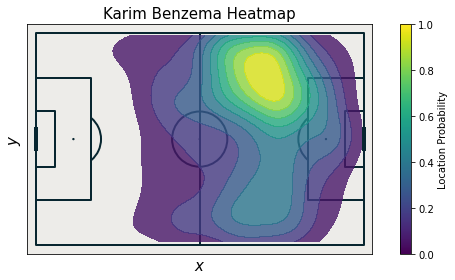

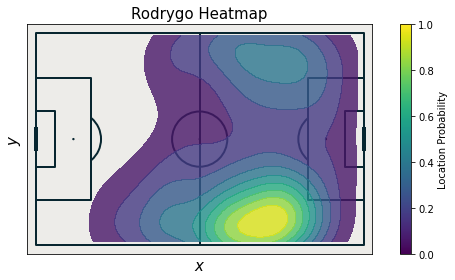

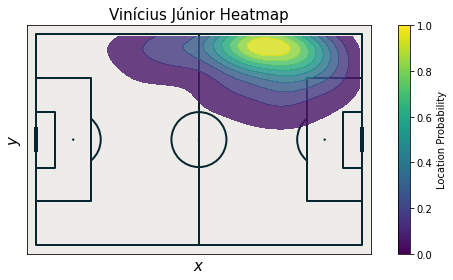

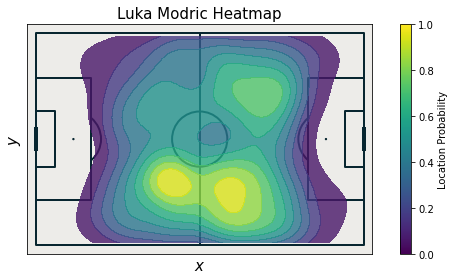

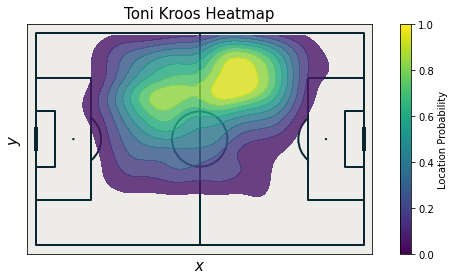

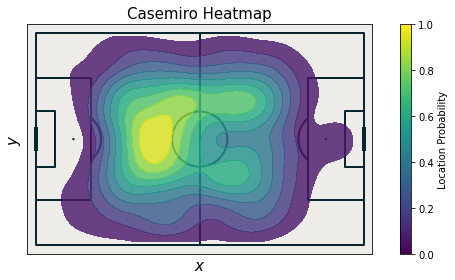

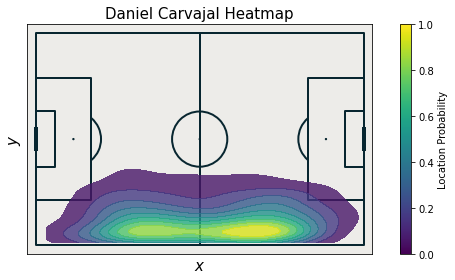

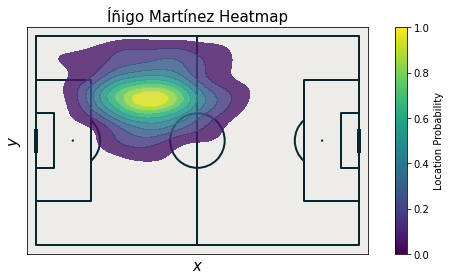

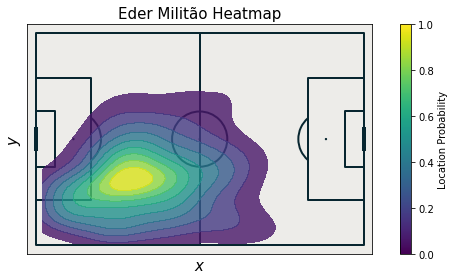

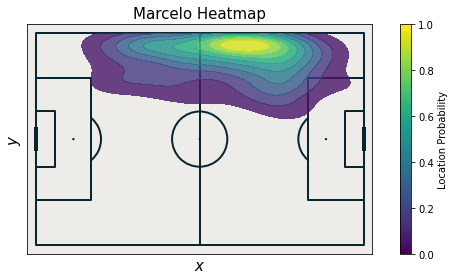

In [64]:
# Read data
data = pd.read_csv("WalkthroughLaLiga.csv")

# Define the player names and their roles
Real_Madrid = {
    "Karim Benzema": "Forward", "Rodrygo": "Forward", "Vinícius Júnior": "Forward",
    "Luka Modric": "Midfielder", "Toni Kroos": "Midfielder", "Casemiro": "Midfielder",
    "Daniel Carvajal": "Defender", "Íñigo Martínez": "Defender", "Eder Militão": "Defender", "Marcelo": "Defender"
}

# Define the opposing team positions
opposing_positions = np.array([
    [115, 60], [100, 40],  # Center-backs
    [110, 75], [100, 20],  # Full-backs
    [77, 45], [95, 60], [80, 65],  # Midfielders
    [65, 77], [60, 20],  # Wingers
    [55, 60]  # Striker
])

# Define the ball position
ball_position = np.array([108, 73])

# Create pitch object with 120 x 80 dimensions
pitch = Pitch(pitch_type='opta', pitch_color='#edece9', axis=True, label=False, line_color='#082630', tick=False)

# Initialize a 3D array to store probabilities for each player (10 players x 120 x 80)
probability_matrix = np.zeros((len(Real_Madrid), 120, 80))

# Generate KDE heat maps and fill the probability matrix
max_prob_positions = []  # To store positions of maximum probability
for i, player in enumerate(Real_Madrid):
    # Filter dataframe to only include passes received by the selected player
    player_data = data[data['receiver'] == player]
    
    # Calculate KDE
    kde = gaussian_kde(np.vstack([player_data.end_x, player_data.end_y]))
    
    # Evaluate KDE probabilities at each x, y coordinate
    x_grid, y_grid = np.mgrid[
        min(player_data.end_x):max(player_data.end_x):120j,
        min(player_data.end_y):max(player_data.end_y):80j
    ]
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
    prob = kde(positions).reshape(x_grid.shape)
    prob = prob / np.max(prob)  # normalize
    
    # Store probability matrix in the 3D array
    probability_matrix[i] = prob

    # Find the position of maximum probability
    max_prob_idx = np.unravel_index(np.argmax(prob, axis=None), prob.shape)
    max_prob_positions.append([max_prob_idx[0], max_prob_idx[1]])

    # Plot KDE heat map
    fig, ax = pitch.draw(figsize=(8, 4))
    
    # Overlay contour plot directly on the pitch
    ax.contourf(x_grid, y_grid, prob, cmap='viridis', alpha=.8, locator=ticker.MaxNLocator(prune='lower'))
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis')
    sm.set_array([])  # Set dummy array to ensure the colorbar knows the range of values
    colorbar = plt.colorbar(sm, ax=ax)
    colorbar.set_label('Location Probability')

    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title(f'{player} Heatmap', fontsize=15)
    
    plt.show()

Final optimized positions:
[[69.09301335 80.19135867]
 [68.02922766 10.30341296]
 [69.53109991 94.36196596]
 [40.27036708 28.92065549]
 [61.31551234 75.20704854]
 [34.70729223 50.65445254]
 [67.04359527  7.18656749]
 [34.41260303 69.92514744]
 [29.22183609 31.71676451]
 [64.54793599 93.45339529]]
Total number of iterations: 93
Objective function value: 10.0


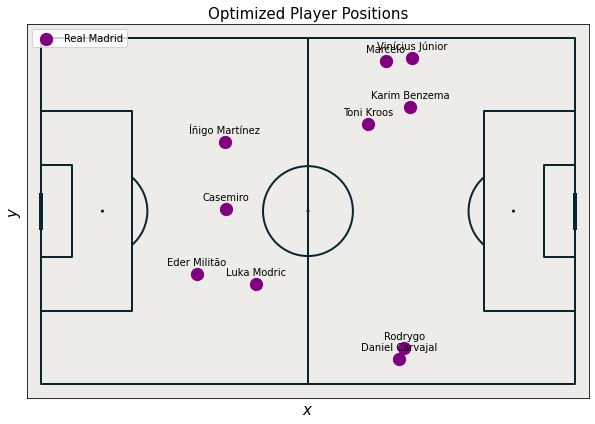

In [53]:
iteration_count = 0
def iteration_callback(xk, convergence):
    global iteration_count
    iteration_count += 1
    print(f"Iteration: {iteration_count}", end='\r')
    
# Convert max_prob_positions to a flat list for differential_evolution
initial_positions = np.array(max_prob_positions).flatten()

# Objective function to maximize summed probability
def objective(x, probability_matrix):
    n_players = len(Real_Madrid)
    total_probability = 0
    
    for i in range(n_players):
        x_idx = int(np.clip(x[2*i], 0, 119))
        y_idx = int(np.clip(x[2*i+1], 0, 79))
        total_probability += probability_matrix[i, x_idx, y_idx]
        
    # We negate the total_probability because differential_evolution minimizes the objective
    return -total_probability

# Function to optimize player positions
def optimize_positions(probability_matrix, initial_positions):
    n_players = len(Real_Madrid)
    bounds = [(0, 119), (0, 79)] * n_players  # Bounds for x and y coordinates for each player
    
    result = differential_evolution(
        objective, bounds, args=(probability_matrix,), strategy='best1bin',
        popsize=20, tol=1e-4, mutation=(0.5, 1), recombination=0.7, seed=42,
        callback=iteration_callback, maxiter=20000, x0=initial_positions
    )
    
    return result

# Main loop to optimize positions
result = optimize_positions(probability_matrix, initial_positions)
optimized_positions = result.x.reshape((len(Real_Madrid), 2))

# Scale optimized positions to fit the 100x100 pitch dimensions
optimized_positions_scaled = np.zeros_like(optimized_positions)
optimized_positions_scaled[:, 0] = optimized_positions[:, 0] * (100 / 120)
optimized_positions_scaled[:, 1] = optimized_positions[:, 1] * (100 / 80)

# Print final positions and iteration count
print(f"Final optimized positions:\n{optimized_positions_scaled}")
print(f"Total number of iterations: {result.nit}")
print(f"Objective function value: {-result.fun}")

# Plot the optimized positions and save the figure
fig, ax = pitch.draw(figsize=(10, 6))

# Plot each player's optimized position
for i, player in enumerate(Real_Madrid):
    ax.scatter(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1], color='purple', s=150, label='Real Madrid' if i == 0 else '')
    ax.text(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1] + 2, player, fontsize=10, ha='center', va='bottom')

# Add a legend
ax.legend(loc='upper left')

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_title('Optimized Player Positions', fontsize=15)

# Save the figure
plt.savefig("optimized_positions.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

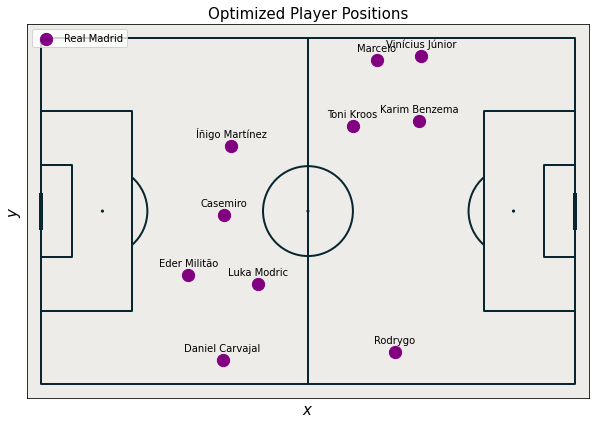

Final optimized positions:
[[70.83270459 75.93496653]
 [66.31100128  9.20174668]
 [71.22469919 94.77790127]
 [40.72842444 28.87152166]
 [58.36034107 74.67539539]
 [34.24677153 48.93816436]
 [34.0080175   6.80492914]
 [35.59647789 68.84933375]
 [27.5830544  31.42374596]
 [62.92701662 93.62289318]]
Total number of iterations: 651
Final objective function value: 9.833203735665004


In [62]:
iteration_count = 0
def iteration_callback(xk, convergence):
    global iteration_count
    iteration_count += 1
    print(f"Iteration: {iteration_count}", end='\r')
    
# Convert max_prob_positions to a flat list for differential_evolution
initial_positions = np.array(max_prob_positions).flatten()

# Objective function to maximize summed probability and apply clustering penalty
def objective(x, probability_matrix):
    n_players = len(Real_Madrid)
    total_probability = 0
    clustering_penalty = 0
    
    positions = x.reshape((n_players, 2))
    
    for i in range(n_players):
        x_idx = int(np.clip(positions[i, 0], 0, 119))
        y_idx = int(np.clip(positions[i, 1], 0, 79))
        total_probability += probability_matrix[i, x_idx, y_idx]
        
    # Apply clustering penalty
    for i in range(n_players):
        for j in range(i + 1, n_players):
            distance = np.linalg.norm(positions[i] - positions[j])
            if distance < 15:  # Penalize distances below 10 units
                clustering_penalty += (10 - distance) ** 2
    
    # We negate the total_probability because differential_evolution minimizes the objective
    return -(total_probability - clustering_penalty)

# Function to optimize player positions
def optimize_positions(probability_matrix, initial_positions):
    n_players = len(Real_Madrid)
    bounds = [(0, 119), (0, 79)] * n_players  # Bounds for x and y coordinates for each player
    
    result = differential_evolution(
        objective, bounds, args=(probability_matrix,), strategy='best1bin',
        popsize=15, tol=1e-3, mutation=(0.5, 1), recombination=0.7, seed=42,
        callback=iteration_callback, maxiter=1000, x0=initial_positions
    )
    
    return result

# Main loop to optimize positions
result = optimize_positions(probability_matrix, initial_positions)
optimized_positions = result.x.reshape((len(Real_Madrid), 2))

# Scale optimized positions to fit the 100x100 pitch dimensions
optimized_positions_scaled = np.zeros_like(optimized_positions)
optimized_positions_scaled[:, 0] = optimized_positions[:, 0] * (100 / 120)
optimized_positions_scaled[:, 1] = optimized_positions[:, 1] * (100 / 80)

# Plot the optimized positions and save the figure
fig, ax = pitch.draw(figsize=(10, 6))

# Plot each player's optimized position
for i, player in enumerate(Real_Madrid):
    ax.scatter(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1], color='purple', s=150, label='Real Madrid' if i == 0 else '')
    ax.text(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1] + 2, player, fontsize=10, ha='center', va='bottom')

# Add a legend
ax.legend(loc='upper left')

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_title('Optimized Player Positions', fontsize=15)

# Save the figure
plt.savefig("optimized_positions.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Print final positions, iteration count, and objective function value
final_objective_value = -result.fun
print(f"Final optimized positions:\n{optimized_positions_scaled}")
print(f"Total number of iterations: {result.nit}")
print(f"Final objective function value: {final_objective_value}")

Final optimized positions:
[[65.40041215 57.38253137]
 [43.40494925 33.60780094]
 [53.28951913 89.93225976]
 [44.55045798 66.46158526]
 [63.99215331 83.68455735]
 [79.71815458 66.50820894]
 [88.88887115 94.25472789]
 [96.63204541 69.10327458]
 [55.15495797 33.44388162]
 [84.83826372 44.49586688]]
Total number of iterations: 1000
Final objective function value: -55.846809912072516


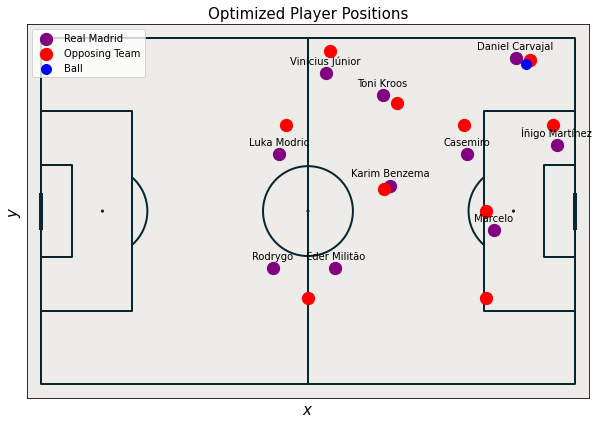

In [63]:
iteration_count = 0
def iteration_callback(xk, convergence):
    global iteration_count
    iteration_count += 1
    print(f"Iteration: {iteration_count}", end='\r')

# Convert max_prob_positions to a flat list for differential_evolution
initial_positions = np.array(max_prob_positions).flatten()

# Objective function to maximize summed probability and apply clustering penalty
def objective(x, probability_matrix, opposing_positions):
    n_players = len(Real_Madrid)
    total_probability = 0
    clustering_penalty = 0
    guarding_penalty = 0
    
    positions = x.reshape((n_players, 2))
    
    for i in range(n_players):
        x_idx = int(np.clip(positions[i, 0], 0, 119))
        y_idx = int(np.clip(positions[i, 1], 0, 79))
        total_probability += probability_matrix[i, x_idx, y_idx]
        
    # Apply clustering penalty
    for i in range(n_players):
        for j in range(i + 1, n_players):
            distance = np.linalg.norm(positions[i] - positions[j])
            if distance < 15:  # Penalize distances below 15 units
                clustering_penalty += (15 - distance) ** 2
    
    # Apply guarding penalty to move players closer to the nearest opposing player
    for i in range(n_players):
        distances_to_opponents = np.linalg.norm(positions[i] - opposing_positions, axis=1)
        nearest_opponent_distance = np.min(distances_to_opponents)
        guarding_penalty += nearest_opponent_distance
    
    # We negate the total_probability because differential_evolution minimizes the objective
    return -(total_probability - clustering_penalty - guarding_penalty)

# Function to optimize player positions
def optimize_positions(probability_matrix, initial_positions, opposing_positions):
    n_players = len(Real_Madrid)
    bounds = [(0, 119), (0, 79)] * n_players  # Bounds for x and y coordinates for each player
    
    result = differential_evolution(
        objective, bounds, args=(probability_matrix, opposing_positions), strategy='best1bin',
        popsize=15, tol=1e-3, mutation=(0.5, 1), recombination=0.7, seed=42,
        callback=iteration_callback, maxiter=1000, x0=initial_positions
    )
    
    return result

# Main loop to optimize positions
result = optimize_positions(probability_matrix, initial_positions, opposing_positions)
optimized_positions = result.x.reshape((len(Real_Madrid), 2))

# Scale optimized positions to fit the 100x100 pitch dimensions
optimized_positions_scaled = np.zeros_like(optimized_positions)
optimized_positions_scaled[:, 0] = optimized_positions[:, 0] * (100 / 120)
optimized_positions_scaled[:, 1] = optimized_positions[:, 1] * (100 / 80)

# Print final positions, iteration count, and objective function value
final_objective_value = -result.fun
print(f"Final optimized positions:\n{optimized_positions_scaled}")
print(f"Total number of iterations: {result.nit}")
print(f"Final objective function value: {final_objective_value}")

# Plot the optimized positions and save the figure
fig, ax = pitch.draw(figsize=(10, 6))

# Plot each player's optimized position
for i, player in enumerate(Real_Madrid):
    ax.scatter(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1], color='purple', s=150, label='Real Madrid' if i == 0 else '')
    ax.text(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1] + 2, player, fontsize=10, ha='center', va='bottom')

# Plot the opposing team's positions
for pos in opposing_positions:
    ax.scatter(pos[0] * (100 / 120), pos[1] * (100 / 80), color='red', s=150, label='Opposing Team' if np.array_equal(pos, opposing_positions[0]) else '')

# Plot the ball position
ax.scatter(ball_position[0] * (100 / 120), ball_position[1] * (100 / 80), color='blue', s=100, label='Ball')

# Add a legend
ax.legend(loc='upper left')

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_title('Optimized Player Positions', fontsize=15)

# Save the figure
plt.savefig("optimized_positions_with_opponents.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

Final optimized positions:
[[83.33250509 25.00468057]
 [79.177208   75.00061355]
 [83.31949313 49.96008777]
 [57.77527235 24.87070957]
 [64.16521595 56.25685414]
 [66.66216321 81.23636898]
 [34.46821192 76.18188078]
 [45.74034541 24.87701838]
 [46.54748942 74.9733431 ]
 [49.99074304 96.16350272]]
Total number of iterations: 571
Final objective function value: -31.30701931017725


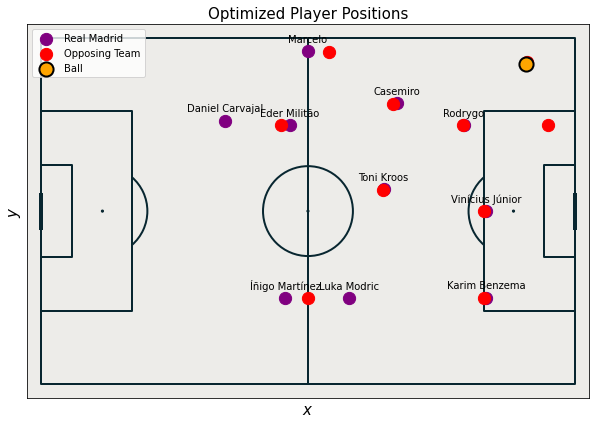

In [65]:
iteration_count = 0
def iteration_callback(xk, convergence):
    global iteration_count
    iteration_count += 1
    print(f"Iteration: {iteration_count}", end='\r')
    
# Convert max_prob_positions to a flat list for differential_evolution
initial_positions = np.array(max_prob_positions).flatten()

# Objective function to maximize summed probability and apply clustering penalty
def objective(x, probability_matrix, opposing_positions, ball_position, Real_Madrid):
    n_players = len(Real_Madrid)
    total_probability = 0
    clustering_penalty = 0
    guarding_penalty = 0

    positions = x.reshape((n_players, 2))
    
    for i in range(n_players):
        x_idx = int(np.clip(positions[i, 0], 0, 119))
        y_idx = int(np.clip(positions[i, 1], 0, 79))
        total_probability += probability_matrix[i, x_idx, y_idx]
        
        # Apply positional constraints based on player roles
        role = Real_Madrid[list(Real_Madrid.keys())[i]]
        if role == "Defender":
            if positions[i, 0] > 60:
                total_probability -= 100  # Strong penalty for defenders being in the attacking half
        elif role == "Midfielder":
            if positions[i, 0] < 40 or positions[i, 0] > 80:
                total_probability -= 50  # Moderate penalty for midfielders being outside the midfield zone
        elif role == "Forward":
            if positions[i, 0] < 60:
                total_probability -= 100  # Strong penalty for forwards being in the defensive half
        
    # Apply clustering penalty
    for i in range(n_players):
        for j in range(i + 1, n_players):
            distance = np.linalg.norm(positions[i] - positions[j])
            if distance < 15:  # Penalize distances below 15 units
                clustering_penalty += (15 - distance) ** 2
    
    # Apply guarding penalty
    for i in range(n_players):
        closest_opponent_distance = np.min(np.linalg.norm(positions[i] - opposing_positions, axis=1))
        guarding_penalty += closest_opponent_distance
    
    # We negate the total_probability because differential_evolution minimizes the objective
    return -(total_probability - clustering_penalty - guarding_penalty)

# Function to optimize player positions
def optimize_positions(probability_matrix, initial_positions, opposing_positions, ball_position, Real_Madrid):
    n_players = len(Real_Madrid)
    bounds = [(0, 119), (0, 79)] * n_players  # Bounds for x and y coordinates for each player
    
    result = differential_evolution(
        objective, bounds, args=(probability_matrix, opposing_positions, ball_position, Real_Madrid), strategy='best1bin',
        popsize=15, tol=1e-3, mutation=(0.5, 1), recombination=0.7, seed=42,
        callback=iteration_callback, maxiter=1000, x0=initial_positions
    )
    
    return result

# Main loop to optimize positions
result = optimize_positions(probability_matrix, initial_positions, opposing_positions, ball_position, Real_Madrid)
optimized_positions = result.x.reshape((len(Real_Madrid), 2))

# Scale optimized positions to fit the 100x100 pitch dimensions
optimized_positions_scaled = np.zeros_like(optimized_positions)
optimized_positions_scaled[:, 0] = optimized_positions[:, 0] * (100 / 120)
optimized_positions_scaled[:, 1] = optimized_positions[:, 1] * (100 / 80)

# Print final positions, iteration count, and objective function value
final_objective_value = -result.fun
print(f"Final optimized positions:\n{optimized_positions_scaled}")
print(f"Total number of iterations: {result.nit}")
print(f"Final objective function value: {final_objective_value}")

# Plot the optimized positions and save the figure
fig, ax = pitch.draw(figsize=(10, 6))

# Plot each player's optimized position
for i, player in enumerate(Real_Madrid.keys()):
    ax.scatter(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1], color='purple', s=150, label='Real Madrid' if i == 0 else '')
    ax.text(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1] + 2, player, fontsize=10, ha='center', va='bottom')

# Plot opposing players' positions
opposing_positions_scaled = np.zeros_like(opposing_positions)
opposing_positions_scaled[:, 0] = opposing_positions[:, 0] * (100 / 120)
opposing_positions_scaled[:, 1] = opposing_positions[:, 1] * (100 / 80)
for i in range(len(opposing_positions)):
    ax.scatter(opposing_positions_scaled[i][0], opposing_positions_scaled[i][1], color='red', s=150, label='Opposing Team' if i == 0 else '')

# Plot the ball position
ball_position_scaled = ball_position * [100 / 120, 100 / 80]
ax.scatter(ball_position_scaled[0], ball_position_scaled[1], color='orange', s=200, label='Ball', edgecolors='black', linewidths=2)

# Add a legend
ax.legend(loc='upper left')

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_title('Optimized Player Positions', fontsize=15)

# Save the figure
plt.savefig("optimized_positions.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

Final optimized positions:
[[81.78884218 50.30273499]
 [89.74000341 95.34580204]
 [94.27781604 69.33873352]
 [54.26727683 95.37353004]
 [63.80633357 58.31475227]
 [65.21052669 83.85730064]
 [47.01655187 11.59211941]
 [47.9359264  76.58334546]
 [38.40612418 69.41567313]
 [45.28757285 29.54213057]]
Total number of iterations: 1000
Final objective function value: -46.880808650263404


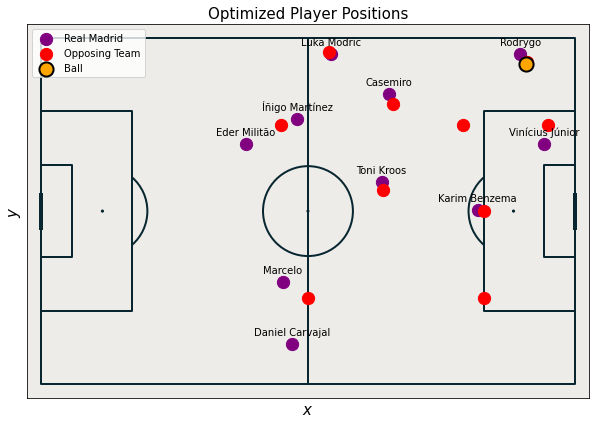

In [66]:
iteration_count = 0
def iteration_callback(xk, convergence):
    global iteration_count
    iteration_count += 1
    print(f"Iteration: {iteration_count}", end='\r')
    
# Convert max_prob_positions to a flat list for differential_evolution
initial_positions = np.array(max_prob_positions).flatten()

# Objective function to maximize summed probability and apply clustering penalty
def objective(x, probability_matrix, opposing_positions, ball_position, Real_Madrid):
    n_players = len(Real_Madrid)
    total_probability = 0
    clustering_penalty = 0
    guarding_penalty = 0
    ball_attraction = 0

    positions = x.reshape((n_players, 2))
    
    for i in range(n_players):
        x_idx = int(np.clip(positions[i, 0], 0, 119))
        y_idx = int(np.clip(positions[i, 1], 0, 79))
        total_probability += probability_matrix[i, x_idx, y_idx]
        
        # Apply positional constraints based on player roles
        role = Real_Madrid[list(Real_Madrid.keys())[i]]
        if role == "Defender":
            if positions[i, 0] > 60:
                total_probability -= 100  # Strong penalty for defenders being in the attacking half
        elif role == "Midfielder":
            if positions[i, 0] < 40 or positions[i, 0] > 80:
                total_probability -= 50  # Moderate penalty for midfielders being outside the midfield zone
        elif role == "Forward":
            if positions[i, 0] < 60:
                total_probability -= 100  # Strong penalty for forwards being in the defensive half
        
    # Apply clustering penalty
    for i in range(n_players):
        for j in range(i + 1, n_players):
            distance = np.linalg.norm(positions[i] - positions[j])
            if distance < 15:  # Penalize distances below 15 units
                clustering_penalty += (15 - distance) ** 2
    
    # Apply guarding penalty
    for i in range(n_players):
        closest_opponent_distance = np.min(np.linalg.norm(positions[i] - opposing_positions, axis=1))
        guarding_penalty += closest_opponent_distance

    # Apply ball attraction penalty (gravity effect)
    for i in range(n_players):
        distance_to_ball = np.linalg.norm(positions[i] - ball_position)
        ball_attraction += 1 / (distance_to_ball + 1)  # +1 to avoid division by zero
    
    # We negate the total_probability because differential_evolution minimizes the objective
    return -(total_probability - clustering_penalty - guarding_penalty + ball_attraction)

# Function to optimize player positions
def optimize_positions(probability_matrix, initial_positions, opposing_positions, ball_position, Real_Madrid):
    n_players = len(Real_Madrid)
    bounds = [(0, 119), (0, 79)] * n_players  # Bounds for x and y coordinates for each player
    
    result = differential_evolution(
        objective, bounds, args=(probability_matrix, opposing_positions, ball_position, Real_Madrid), strategy='best1bin',
        popsize=15, tol=1e-3, mutation=(0.5, 1), recombination=0.7, seed=42,
        callback=iteration_callback, maxiter=1000, x0=initial_positions
    )
    
    return result

# Main loop to optimize positions
result = optimize_positions(probability_matrix, initial_positions, opposing_positions, ball_position, Real_Madrid)
optimized_positions = result.x.reshape((len(Real_Madrid), 2))

# Scale optimized positions to fit the 100x100 pitch dimensions
optimized_positions_scaled = np.zeros_like(optimized_positions)
optimized_positions_scaled[:, 0] = optimized_positions[:, 0] * (100 / 120)
optimized_positions_scaled[:, 1] = optimized_positions[:, 1] * (100 / 80)

# Print final positions, iteration count, and objective function value
final_objective_value = -result.fun
print(f"Final optimized positions:\n{optimized_positions_scaled}")
print(f"Total number of iterations: {result.nit}")
print(f"Final objective function value: {final_objective_value}")

# Plot the optimized positions and save the figure
fig, ax = pitch.draw(figsize=(10, 6))

# Plot each player's optimized position
for i, player in enumerate(Real_Madrid.keys()):
    ax.scatter(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1], color='purple', s=150, label='Real Madrid' if i == 0 else '')
    ax.text(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1] + 2, player, fontsize=10, ha='center', va='bottom')

# Plot opposing players' positions
opposing_positions_scaled = np.zeros_like(opposing_positions)
opposing_positions_scaled[:, 0] = opposing_positions[:, 0] * (100 / 120)
opposing_positions_scaled[:, 1] = opposing_positions[:, 1] * (100 / 80)
for i in range(len(opposing_positions)):
    ax.scatter(opposing_positions_scaled[i][0], opposing_positions_scaled[i][1], color='red', s=150, label='Opposing Team' if i == 0 else '')

# Plot the ball position
ball_position_scaled = ball_position * [100 / 120, 100 / 80]
ax.scatter(ball_position_scaled[0], ball_position_scaled[1], color='orange', s=200, label='Ball', edgecolors='black', linewidths=2)

# Add a legend
ax.legend(loc='upper left')

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_title('Optimized Player Positions', fontsize=15)

# Save the figure
plt.savefig("optimized_positions.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

Final optimized positions:alue: -354.4221304458905
[[96.559611   80.87953013]
 [71.74423891 81.85777841]
 [78.29147562 73.39047712]
 [61.63699679 62.71283528]
 [92.3737456  60.33983292]
 [52.27618833 25.06381445]
 [29.02519339 95.30186326]
 [41.28669444 14.27691881]
 [47.16163296 85.7079418 ]
 [39.52980668 81.88894215]]
Total number of iterations: 10
Final objective function value: 9645.57786955411


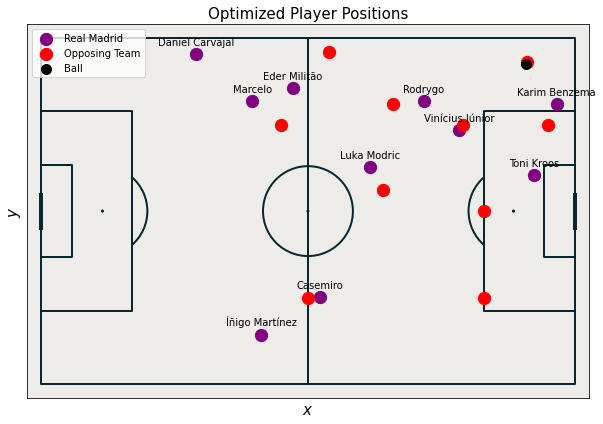

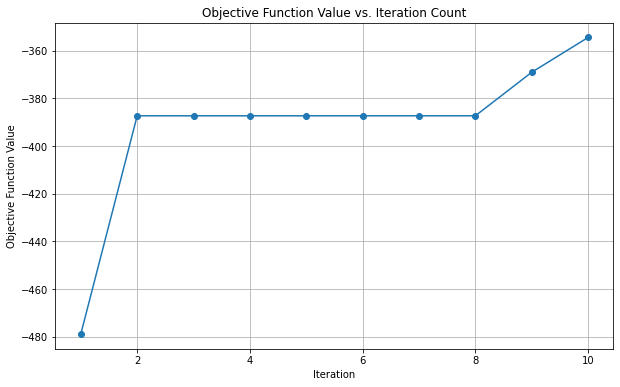

In [83]:
iteration_count = 0
objective_values = []
def iteration_callback(xk, convergence):
    global iteration_count, objective_values
    iteration_count += 1
    # Compute current objective value
    current_objective_value = objective(xk, probability_matrix, opposing_positions, ball_position, Real_Madrid)
    objective_values.append(-current_objective_value)  # Negate because we minimize the negative of the objective
    print(f"Iteration: {iteration_count}, Objective Value: {objective_values[-1]}", end='\r')

# Convert max_prob_positions to a flat list for differential_evolution
initial_positions = np.array(max_prob_positions).flatten()

# Objective function to maximize summed probability and apply clustering penalty
def objective(x, probability_matrix, opposing_positions, ball_position, Real_Madrid):
    n_players = len(Real_Madrid)
    total_probability = 0
    clustering_penalty = 0
    guarding_penalty = 0
    ball_attraction = 0
    assignment_penalty = 0

    positions = x.reshape((n_players, 2))
    
    for i in range(n_players):
        x_idx = int(np.clip(positions[i, 0], 0, 119))
        y_idx = int(np.clip(positions[i, 1], 0, 79))
        total_probability += probability_matrix[i, x_idx, y_idx]
        
        # Apply positional constraints based on player roles
        role = Real_Madrid[list(Real_Madrid.keys())[i]]
        if role == "Defender":
            if positions[i, 0] > 60:
                total_probability -= 100  # Strong penalty for defenders being in the attacking half
        elif role == "Midfielder":
            if positions[i, 0] < 40 or positions[i, 0] > 80:
                total_probability -= 50  # Moderate penalty for midfielders being outside the midfield zone
        elif role == "Forward":
            if positions[i, 0] < 60:
                total_probability -= 100  # Strong penalty for forwards being in the defensive half
        
    # Apply clustering penalty
    for i in range(n_players):
        for j in range(i + 1, n_players):
            distance = np.linalg.norm(positions[i] - positions[j])
            if distance < 15:  # Penalize distances below 15 units
                clustering_penalty += (15 - distance) ** 2
    
    # Apply guarding penalty
    for i in range(n_players):
        closest_opponent_distance = np.min(np.linalg.norm(positions[i] - opposing_positions, axis=1))
        guarding_penalty += closest_opponent_distance

    # Apply ball attraction penalty (gravity effect)
    for i in range(n_players):
        distance_to_ball = np.linalg.norm(positions[i] - ball_position)
        ball_attraction += 1 / (distance_to_ball + 1)  # +1 to avoid division by zero
    
    # Ensure unique guarding assignments using the Hungarian algorithm
    cost_matrix = np.zeros((n_players, len(opposing_positions)))
    for i in range(n_players):
        for j in range(len(opposing_positions)):
            cost_matrix[i, j] = np.linalg.norm(positions[i] - opposing_positions[j])
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    assignment_penalty = cost_matrix[row_ind, col_ind].sum()
    
    # We negate the total_probability because differential_evolution minimizes the objective
    return -(total_probability - clustering_penalty - guarding_penalty + ball_attraction - assignment_penalty)

# Function to optimize player positions
def optimize_positions(probability_matrix, initial_positions, opposing_positions, ball_position, Real_Madrid):
    n_players = len(Real_Madrid)
    bounds = [(0, 119), (0, 79)] * n_players  # Bounds for x and y coordinates for each player
    
    result = differential_evolution(
        objective, bounds, args=(probability_matrix, opposing_positions, ball_position, Real_Madrid), strategy='best1bin',
        popsize=15, tol=1e-3, mutation=(0.5, 1), recombination=0.7, seed=42,
        callback=iteration_callback, maxiter=10, x0=initial_positions)
    
    return result

# Main loop to optimize positions
result = optimize_positions(probability_matrix, initial_positions, opposing_positions, ball_position, Real_Madrid)
optimized_positions = result.x.reshape((len(Real_Madrid), 2))

# Scale optimized positions to fit the 100x100 pitch dimensions
optimized_positions_scaled = np.zeros_like(optimized_positions)
optimized_positions_scaled[:, 0] = optimized_positions[:, 0] * (100 / 120)
optimized_positions_scaled[:, 1] = optimized_positions[:, 1] * (100 / 80)

# Print final positions, iteration count, and objective function value
final_objective_value = -result.fun + 10000
print(f"Final optimized positions:\n{optimized_positions_scaled}")
print(f"Total number of iterations: {result.nit}")
print(f"Final objective function value: {final_objective_value}")

# Plot the optimized positions and save the figure
fig, ax = pitch.draw(figsize=(10, 6))

# Plot each player's optimized position
for i, player in enumerate(Real_Madrid.keys()):
    ax.scatter(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1], color='purple', s=150, label='Real Madrid' if i == 0 else '')
    ax.text(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1] + 2, player, fontsize=10, ha='center', va='bottom')

# Plot opposing players' positions
opposing_positions_scaled = np.zeros_like(opposing_positions)
opposing_positions_scaled[:, 0] = opposing_positions[:, 0] * (100 / 120)
opposing_positions_scaled[:, 1] = opposing_positions[:, 1] * (100 / 80)
for i in range(len(opposing_positions)):
    ax.scatter(opposing_positions_scaled[i][0], opposing_positions_scaled[i][1], color='red', s=150, label='Opposing Team' if i == 0 else '')

# Plot ball position
ball_position_scaled = ball_position * [100 / 120, 100 / 80]
ax.scatter(ball_position_scaled[0], ball_position_scaled[1], color='black', s=100, label='Ball')

# Add a legend
ax.legend(loc='upper left')

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_title('Optimized Player Positions', fontsize=15)

# Save the figure
plt.savefig("optimized_positions.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Plot the objective function value vs. iteration count
plt.figure(figsize=(10, 6))
plt.plot(range(1, iteration_count + 1), objective_values, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Objective Function Value vs. Iteration Count')
plt.grid(True)
plt.savefig("objective_function_vs_iteration.png", dpi=300, bbox_inches='tight')
plt.show()

In [111]:
iteration_count = 0
objective_values = []

def iteration_callback(xk, convergence):
    global iteration_count, objective_values
    iteration_count += 1
    current_objective_value = objective(xk, probability_matrix, opposing_positions, ball_position, Real_Madrid)
    objective_values.append(current_objective_value)
    print(f"Iteration: {iteration_count}, Objective Value: {objective_values[-1]}", end='\r')

# Convert max_prob_positions to a flat list for differential_evolution
initial_positions = np.array(max_prob_positions).flatten()

# Objective function to minimize summed probability and apply clustering penalty
def objective(x, probability_matrix, opposing_positions, ball_position, Real_Madrid):
    n_players = len(Real_Madrid)
    total_penalty = 0
    clustering_penalty = 0
    guarding_penalty = 0
    ball_attraction = 0
    assignment_penalty = 0

    positions = x.reshape((n_players, 2))
    
    for i in range(n_players):
        x_idx = int(np.clip(positions[i, 0], 0, 119))
        y_idx = int(np.clip(positions[i, 1], 0, 79))
        total_penalty -= probability_matrix[i, x_idx, y_idx]  # Add the probability as a negative penalty to be minimized
        
        # Apply positional constraints based on player roles
        role = Real_Madrid[list(Real_Madrid.keys())[i]]
        if role == "Defender":
            if positions[i, 0] > 60:
                total_penalty += 100  # Strong penalty for defenders being in the attacking half
        elif role == "Midfielder":
            if positions[i, 0] < 40 or positions[i, 0] > 80:
                total_penalty += 50  # Moderate penalty for midfielders being outside the midfield zone
        elif role == "Forward":
            if positions[i, 0] < 60:
                total_penalty += 100  # Strong penalty for forwards being in the defensive half
        
    # Apply clustering penalty
    for i in range(n_players):
        for j in range(i + 1, n_players):
            distance = np.linalg.norm(positions[i] - positions[j])
            if distance < 15:  # Penalize distances below 15 units
                clustering_penalty += (15 - distance) ** 2
    
    # Apply guarding penalty
    for i in range(n_players):
        closest_opponent_distance = np.min(np.linalg.norm(positions[i] - opposing_positions, axis=1))
        guarding_penalty += closest_opponent_distance

    # Apply ball attraction penalty (gravity effect)
    for i in range(n_players):
        distance_to_ball = np.linalg.norm(positions[i] - ball_position)
        ball_attraction += 1 / (distance_to_ball + 1)  # +1 to avoid division by zero
    
    # Ensure unique guarding assignments using the Hungarian algorithm
    cost_matrix = np.zeros((n_players, len(opposing_positions)))
    for i in range(n_players):
        for j in range(len(opposing_positions)):
            cost_matrix[i, j] = np.linalg.norm(positions[i] - opposing_positions[j])
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    assignment_penalty = cost_matrix[row_ind, col_ind].sum()
    
    # Combine all components to form the objective function
    return total_penalty + clustering_penalty + guarding_penalty - ball_attraction + assignment_penalty

# Function to optimize player positions
def optimize_positions(probability_matrix, initial_positions, opposing_positions, ball_position, Real_Madrid):
    n_players = len(Real_Madrid)
    bounds = [(0, 119), (0, 79)] * n_players  # Bounds for x and y coordinates for each player
    
    result = differential_evolution(
        objective, bounds, args=(probability_matrix, opposing_positions, ball_position, Real_Madrid), strategy='best1bin',
        popsize=15, tol=1e-3, mutation=(0.5, 1), recombination=0.7, seed=42,
        callback=iteration_callback, maxiter=1000, x0=initial_positions)
    
    return result

# Main loop to optimize positions
result = optimize_positions(probability_matrix, initial_positions, opposing_positions, ball_position, Real_Madrid)
optimized_positions = result.x.reshape((len(Real_Madrid), 2))

# Scale optimized positions to fit the 100x100 pitch dimensions
optimized_positions_scaled = np.zeros_like(optimized_positions)
optimized_positions_scaled[:, 0] = optimized_positions[:, 0] * (100 / 120)
optimized_positions_scaled[:, 1] = optimized_positions[:, 1] * (100 / 80)

# Print final positions, iteration count, and objective function value
final_objective_value = result.fun
print(f"Final optimized positions:\n{optimized_positions_scaled}")
print(f"Total number of iterations: {result.nit}")
print(f"Final objective function value: {final_objective_value}")

# Plot the optimized positions and save the figure
fig, ax = pitch.draw(figsize=(10, 6))

# Plot each player's optimized position
for i, player in enumerate(Real_Madrid.keys()):
    ax.scatter(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1], color='purple', s=150, label='Real Madrid' if i == 0 else '')
    ax.text(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1] + 2, player, fontsize=10, ha='center', va='bottom')

# Plot opposing players' positions
opposing_positions_scaled = np.zeros_like(opposing_positions)
opposing_positions_scaled[:, 0] = opposing_positions[:, 0] * (100 / 120)
opposing_positions_scaled[:, 1] = opposing_positions[:, 1] * (100 / 80)
for i in range(len(opposing_positions)):
    ax.scatter(opposing_positions_scaled[i][0], opposing_positions_scaled[i][1], color='red', s=150, label='Opposing Team' if i == 0 else '')

# Plot ball position
ball_position_scaled = ball_position * [100 / 120, 100 / 80]
ax.scatter(ball_position_scaled[0], ball_position_scaled[1], color='black', s=100, label='Ball')

# Add a legend
ax.legend(loc='upper left')

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)

# Save the figure
plt.savefig("optimized_positions.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Plot the objective function value vs. iteration count
plt.figure(figsize=(10, 6))
plt.plot(range(1, iteration_count + 1), objective_values, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.grid(True)
plt.savefig("objective_function_vs_iteration.png", dpi=300, bbox_inches='tight')
plt.show()

KeyboardInterrupt: 

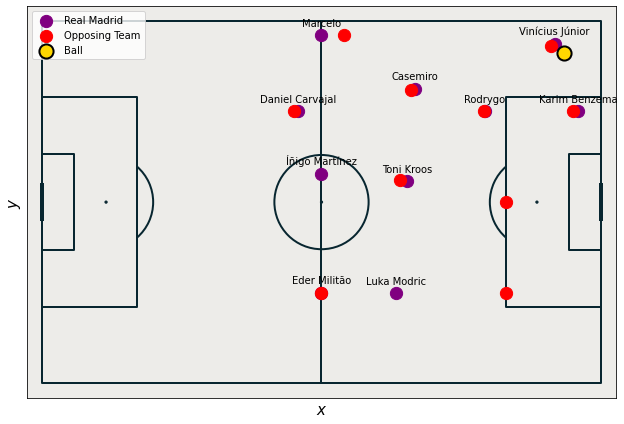

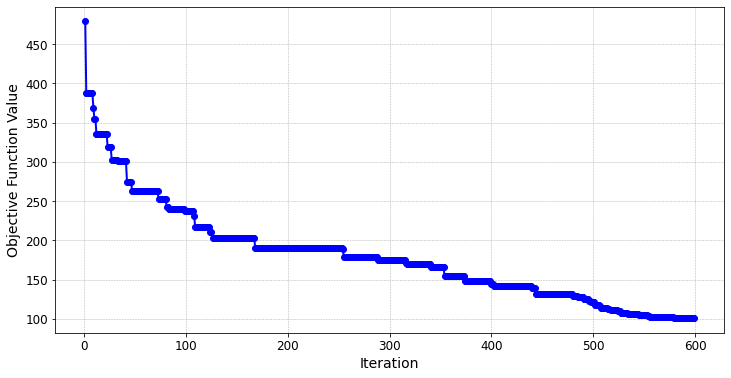

In [110]:
# Plot the optimized positions and save the figure
fig, ax = pitch.draw(figsize=(10, 6))

# Plot each player's optimized position
for i, player in enumerate(Real_Madrid.keys()):
    ax.scatter(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1], color='purple', s=150, label='Real Madrid' if i == 0 else '')
    ax.text(optimized_positions_scaled[i][0], optimized_positions_scaled[i][1] + 2, player, fontsize=10, ha='center', va='bottom')

# Plot opposing players' positions
opposing_positions_scaled = np.zeros_like(opposing_positions)
opposing_positions_scaled[:, 0] = opposing_positions[:, 0] * (100 / 120)
opposing_positions_scaled[:, 1] = opposing_positions[:, 1] * (100 / 80)
for i in range(len(opposing_positions)):
    ax.scatter(opposing_positions_scaled[i][0], opposing_positions_scaled[i][1], color='red', s=150, label='Opposing Team' if i == 0 else '')

# Plot ball position using a gold dot
ball_position_scaled = ball_position * [100 / 120, 100 / 80]
ax.scatter(ball_position_scaled[0], ball_position_scaled[1], color='gold', edgecolor = 'black', s=200, label='Ball', linewidths = 2)

# Add a legend
ax.legend(loc='upper left')

ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)

# Save the figure
plt.savefig("optimized_positions_ballincorner.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Plot the objective function value vs. iteration count
plt.figure(figsize=(12, 6))
plt.plot(range(1, iteration_count + 1), objective_values, marker='o', color='blue', linestyle='-', linewidth=2, markersize=6)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Objective Function Value', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the plot
plt.savefig("objective_function_vs_iteration_ballincorner.png", dpi=300, bbox_inches='tight')
plt.show()